In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import os
import numpy as np
import cartopy.crs as ccrs
import json
import os
import seaborn as sns
from PIL import Image

In [15]:
from astropy.table import Table

In [16]:
os.chdir('/home/walml/repos/zoobot')

## Remove DR1/2 repeats

In [23]:
dr1_dr2 = Table.read('/media/walml/beta/galaxy_zoo/decals/dr1_dr2/subjects/decals_dr1_and_dr2_with_subj_id.csv').to_pandas()

In [24]:
del dr1_dr2['_id']

Check if images exist and are properly filled - we'll need this later, to see what was uploaded and if any classified subjects were bad

In [25]:
# copied from https://github.com/zooniverse/decals/blob/master/decals/a_download_decals/get_images/download_images_threaded.py#L390, used for DR5
def few_missing_pixels(img, badmax_limit=0.2):
    """
    Find if img contains few NaN pixels e.g. from incomplete imaging
    Args:
        img (np.array): multi-band (i.e. 3-dim) pixel data to check
        badmax_limit(float): maximum ratio of empty pixels for image to be considered 'correct' e.g. 0.2 (20%)
    Returns:
        (bool) True if few NaN pixels, else False
    """
    badmax = 0.
    for j in range(img.shape[0]):
        band = img[j, :, :]
        nbad = (band == 0.).sum() + np.isnan(band).sum()  # count of bad pixels in band
        fracbad = nbad / np.prod(band.shape)  # fraction of bad pixels in band
        badmax = max(badmax, fracbad)  # update worst band fraction

    # if worst fraction of bad pixels is < badmax_limit, consider image as 'good'
    if badmax < badmax_limit:
        return True
    else:
        return False

In [26]:
def is_jpeg_filled(loc):
    if os.path.isfile(loc):
        data = np.array(Image.open(loc))
        return few_missing_pixels(data)
    else:
        return False


In [34]:
dr1_dr2['dr1_jpeg_loc'] = dr1_dr2['iauname'].apply(lambda x: '/media/walml/beta/galaxy_zoo/decals/dr1_dr2/png/dr1/standard/' + x + '_standard.jpeg')
dr1_dr2['dr2_jpeg_loc'] = dr1_dr2['iauname'].apply(lambda x: '/media/walml/beta/galaxy_zoo/decals/dr1_dr2/png/decals-dr2/standard/' + x +'.jpeg')
dr1_dr2['dr1_jpeg_exists'] = dr1_dr2['dr1_jpeg_loc'].apply(os.path.isfile)
dr1_dr2['dr2_jpeg_exists'] = dr1_dr2['dr2_jpeg_loc'].apply(os.path.isfile)

In [35]:
new_image_checks = True  # takes about 30 mins
if new_image_checks:
    dr1_dr2['dr1_jpeg_filled'] = dr1_dr2['dr1_jpeg_loc'].apply(is_jpeg_filled)
    dr1_dr2['dr2_jpeg_filled'] = dr1_dr2['dr2_jpeg_loc'].apply(is_jpeg_filled)
    dr1_dr2['good_subject_image'] = dr1_dr2['dr1_jpeg_filled'] | dr1_dr2['dr2_jpeg_filled'] 
    dr1_dr2.to_csv('dr1_dr2_with_extra_checks.csv', index=False)
else:
    dr1_dr2 = pd.read_csv('dr1_dr2_with_extra_checks.csv')

In [36]:
dr1_dr2['good_subject_image'].value_counts()

True     95366
False     8346
Name: good_subject_image, dtype: int64

In [37]:
(dr1_dr2['iauname'].value_counts() > 1).sum()

2413

In [38]:
counts = dr1_dr2['iauname'].value_counts() > 1
repeating_iaunames = counts[counts].index.values
repeating_iaunames = [a for a in repeating_iaunames]

In [39]:
len(repeating_iaunames)

2413

In [40]:
repeating_subject_ids = dr1_dr2[dr1_dr2['iauname'].isin(repeating_iaunames)]['subject_id']
len(repeating_subject_ids), len(set(repeating_subject_ids))

(4826, 4826)

In [41]:
dr1_dr2[dr1_dr2['iauname'] == 'J154253.87+060230.5'].squeeze()

,col0,absolute_size,background,bad_image,band,bands,camera,counters,data_release,dec,...,subhalo_id,survey,subject_id,dr1_jpeg_loc,dr2_jpeg_loc,dr1_jpeg_exists,dr2_jpeg_exists,dr1_jpeg_filled,dr2_jpeg_filled,good_subject_image
26666,26666,10.090934,NaN,NaN,NaN,NaN,NaN,"{""feature"": 0, ""smooth"": 0, ""star"": 0}",DR1,6.041827,...,NaN,decals,55a7d7ae7a726119cd00682a,/media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...,/media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...,False,True,False,True,True
70144,70144,10.090934,NaN,NaN,NaN,NaN,NaN,"{""star"": 0, ""smooth"": 0, ""feature"": 0}",DR2,6.041827,...,NaN,decals,56f3dcb25925d900420269df,/media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...,/media/walml/beta/galaxy_zoo/decals/dr1_dr2/pn...,False,True,False,True,True


Different: _id, data_release, nobs_max (new), retire_at
    
This repeat is a galaxy uploaded in both DR1 and DR2. That's always true:


In [42]:
dr1_dr2.duplicated('iauname').sum(), dr1_dr2.duplicated(subset=['iauname', 'data_release']).sum()

(2413, 0)

In [43]:
dr1_dr2['data_release'].value_counts()

DR2    61595
DR1    42117
Name: data_release, dtype: int64

So the subjects file includes 2.4k subjects in both.

Were they classified twice? (no)


In [44]:
# load classifications
dr1_c = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/raw/classifications/2017-10-15_galaxy_zoo_decals_classifications.csv')
dr2_c = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/raw/classifications/2017-10-15_galaxy_zoo_decals_dr2_classifications.csv')

In [45]:
dr1_c['decals-0'].value_counts()

a-0    914957
a-1    489894
a-2    312316
a-3         4
Name: decals-0, dtype: int64

In [46]:
dr2_c['decals-0'].value_counts()

a-0    1284174
a-1     683792
a-2     507486
a-3          8
Name: decals-0, dtype: int64

In [47]:
# all classified subjects are in the subject catalog
dr1_c['subject_id'].isin(dr1_dr2['subject_id']).mean(), dr2_c['subject_id'].isin(dr1_dr2['subject_id']).mean()

(1.0, 1.0)

In [48]:
dr1_c_with_s = pd.merge(dr1_c, dr1_dr2, on='subject_id', how='inner')

In [49]:
dr1_subjects_per_iauname = dr1_c_with_s.groupby('subject_id').agg({'iauname': lambda x: len(set(x))}).reset_index()
dr1_subjects_per_iauname['iauname'].value_counts()

1    32430
Name: iauname, dtype: int64

In [50]:
dr2_c_with_s = pd.merge(dr2_c, dr1_dr2, on='subject_id', how='inner')

In [51]:
dr2_subjects_per_iauname = dr2_c_with_s.groupby('subject_id').agg({'iauname': lambda x: len(set(x))}).reset_index()
dr2_subjects_per_iauname['iauname'].value_counts()

1    61594
Name: iauname, dtype: int64

In [52]:
set(dr1_c_with_s['iauname']).intersection(dr2_c_with_s['iauname'])

set()

There are no iaunames with multiple classifications in a data release, and no iaunames classified in both. 

Simply put - there are no duplicate classifications :)

The 2.4k iaunames in both DR1/DR2 subjects were only ever classified in DR2. Simple proof:

In [53]:
assert dr1_c_with_s['iauname'].isin(repeating_iaunames).sum() == 0

In [54]:
assert len(set(dr2_c_with_s['iauname']).intersection(repeating_iaunames)) == len(repeating_iaunames)

This means all the classifications are for single, non-duplicate subjects.

But how about the other half - were all subjects classified?

In [57]:
dr2_subjects = dr1_dr2.query('data_release == "DR2"')
dr2_subjects_not_classified = dr2_subjects[~dr2_subjects['subject_id'].isin(dr2_c['subject_id'])]
len(dr2_subjects_not_classified)  # only one DR2 subject wasn't classified

1

In [58]:
dr1_subjects = dr1_dr2.query('data_release == "DR1"')
dr1_subjects_not_classified = dr1_subjects[~dr1_subjects['subject_id'].isin(dr1_c['subject_id'])]
dr1_subjects_not_classified_not_repeat = dr1_subjects_not_classified[~dr1_subjects_not_classified['iauname'].isin(repeating_iaunames)]
len(dr1_subjects_not_classified), len(dr1_subjects_not_classified_not_repeat)

(9687, 7274)

7.5k (9.6k not classified minus the 2.4k repeats) DR1 subjects have no classifications. Why is that?

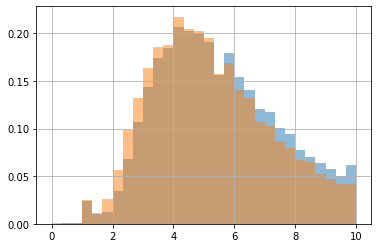

In [59]:
_, bins = np.histogram(np.linspace(0, 10), bins=30)
dr1_subjects_not_classified['petrorad_r'].hist(bins=bins, density=True, alpha=.5)
dr1_subjects['petrorad_r'].hist(bins=bins, density=True, alpha=.5)

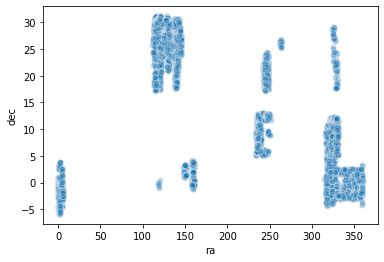

In [60]:
sns.scatterplot(data=dr1_subjects_not_classified, x='ra', y='dec', alpha=.3)

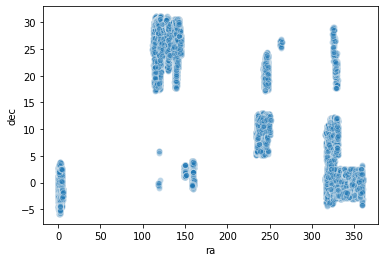

In [61]:
sns.scatterplot(data=dr1_subjects, x='ra', y='dec', alpha=.3)

There's no obvious trend in size or location. For DR2, about 1/3rd of galaxies had bad images, and this would give about the right number of missing galaxies here. Perhaps the subject catalog includes those bad-image galaxies. 

Let's check the images - maybe they were bad.


## DR1/2 galaxies with bad images which were classified 

In [62]:
dr2_with_bad_dr5_fits = pd.read_csv('notebooks/catalogs/dr2_with_bad_dr5_fits.csv')

In [63]:
dr2_with_bad_dr5_fits = pd.merge(dr2_with_bad_dr5_fits, dr1_dr2[['iauname', 'subject_id']], how='inner')
len(dr2_with_bad_dr5_fits)  # goes up as dr1_dr2 subject catalog includes some duplicates, iauname uploaded twice

2119

In [64]:
dr2_with_bad_dr5_fits['png_loc'] = dr2_with_bad_dr5_fits['png_loc'].str.decode('utf8')

In [70]:
dr1_dr2['dr1_jpeg_exists'].value_counts()

False    71282
True     32430
Name: dr1_jpeg_exists, dtype: int64

In [71]:
dr1_dr2.query('data_release == "DR1"')['dr1_jpeg_exists'].value_counts()  # 9687 - exactly as many as weren't uploaded, see above!

True     32430
False     9687
Name: dr1_jpeg_exists, dtype: int64

In [72]:
dr1_dr2['dr2_jpeg_exists'].value_counts()

True     64054
False    39658
Name: dr2_jpeg_exists, dtype: int64

In [74]:
dr1_dr2.query('data_release == "DR2"')['dr2_jpeg_exists'].value_counts()

True    61595
Name: dr2_jpeg_exists, dtype: int64

In [75]:
pd.value_counts(dr1_dr2['dr1_jpeg_exists'] | dr1_dr2['dr2_jpeg_exists'])

True     96484
False     7228
dtype: int64

We have every DR2 jpeg, but we're missing 9687 DR1 jpegs. 

These are exactly (from the numbers, 9867 missing subjects and 9867 not classified) the subjects that weren' classified in DR1.

2k of these were classified later in DR2, and 7k were simply never classified.

This final 7k is perhaps a missing set, as they were in the DR1/2 subject catalog (hence not re-uploaded) but were in fact never classified. I could pass these over to Tobias, but I'm not waiting longer.

In [76]:
# with open('dr1_subjects_never_classified.txt', 'w') as f:
#     for iauname in dr1_subjects_not_classified_not_repeat['iauname']:
#         f.write(iauname + '/n')
# # maybe Tobias can eventually upload these along with DR8

Finally, of the galaxies which were classified, were any classified with probably bad images?

(Note - slow, takes like 30 mins!)

# Aggregated 

Finally, create the aggregated classifications. This is run using the raw classifications at the moment, as this notebook makes no changes.

In [ ]:
# nope, this is for Nair comparison - same for panoptes probably
# aggregated = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/output/dr2_predictions_with_subject.csv')

In [77]:
# also has a version with predictions added, most likely etc
aggregated = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/votes/dr2_aggregated_votes.csv')

In [78]:
aggregated

,subject_id,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,how-rounded_completely,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,spiral-arm-count_more-than-4_fraction,bulge-size_total-votes,bulge-size_none_fraction,bulge-size_obvious_fraction,bulge-size_dominant_fraction,merging_total-votes,merging_merger_fraction,merging_tidal-debris_fraction,merging_both_fraction,merging_neither_fraction
0,55a7d7a27a726119cd00000b,19,15,11,16,2,1,2,13,2,...,0.125,13,0.000000,0.923077,0.076923,34,0.147059,0.088235,0.088235,0.676471
1,55a7d7a27a726119cd00000c,33,2,6,28,5,0,1,1,1,...,0.000,1,0.000000,1.000000,0.000000,35,0.200000,0.085714,0.028571,0.685714
2,55a7d7a27a726119cd00000d,36,1,10,23,13,0,0,1,0,...,0.000,1,0.000000,1.000000,0.000000,37,0.027027,0.027027,0.000000,0.945946
3,55a7d7a27a726119cd00000e,32,15,6,16,16,0,0,15,0,...,0.250,15,0.266667,0.733333,0.000000,47,0.021277,0.042553,0.021277,0.914894
4,55a7d7a27a726119cd00000f,40,6,7,10,29,1,0,6,0,...,0.000,6,0.166667,0.666667,0.166667,46,0.086957,0.043478,0.021739,0.847826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94019,56f3deb65925d90042037015,6,12,22,4,1,1,0,12,0,...,0.000,12,0.500000,0.500000,0.000000,18,0.277778,0.111111,0.000000,0.611111
94020,56f3deb65925d90042037017,21,15,4,17,4,0,0,15,0,...,0.000,15,0.333333,0.600000,0.066667,36,0.277778,0.027778,0.083333,0.611111
94021,56f3deb65925d90042037019,22,15,3,2,16,4,11,4,11,...,0.000,4,0.250000,0.750000,0.000000,37,0.540541,0.000000,0.108108,0.351351
94022,56f3deb65925d9004203701b,30,2,8,26,3,1,0,2,0,...,0.000,2,0.000000,0.000000,1.000000,32,0.093750,0.093750,0.000000,0.812500


In [87]:
assert not any(aggregated.duplicated('subject_id'))

In [89]:
assert not any(pd.isna(aggregated['subject_id']))

In [90]:
aggregated_with_subj = pd.merge(aggregated, dr1_dr2, how='inner', on='subject_id')
assert len(aggregated_with_subj) == len(aggregated)
# this is okay because although DR1/DR2 subjects include duplicate iaunames, there are no duplicate subject ids

In [92]:
assert not any(aggregated_with_subj.duplicated('iauname'))
# and iaunames aren't duplicated because no iauname was actually classified in both DR1 and DR2, so the duplicates only appear once (from DR2) in aggregated

In [94]:
aggregated_with_subj['good_subject_image'].value_counts()

True     92960
False     1064
Name: good_subject_image, dtype: int64

In [98]:
aggregated_good_subj = aggregated_with_subj.query('good_subject_image')

In [99]:
aggregated_good_subj.to_csv('dr2_aggregated_votes_good_subjects.csv', index=False)